# **GPU para Digits - Primer código en GPU**
*Universidad Nacional Autónoma de México*
## Laboratorio Avanzado de Procesamiento de Imágenes
Académicos:
* Dr. Boris Escalante Ramírez

### Creado por: **Sebastián González Juárez**

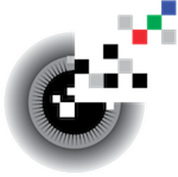
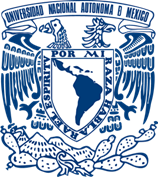

## A) Imports + device + semilla.

In [1]:
import sys, math, random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import pennylane as qml

SEED = 1337
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

torch.set_default_dtype(torch.float32)
DEVICE = torch.device("cuda")

print("Python:", sys.version.split()[0])
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("GPU:", torch.cuda.get_device_name(0))
print("PennyLane:", qml.__version__)

_ = torch.rand(1, device=DEVICE)

Python: 3.11.14
Torch: 2.5.1+cu121 | CUDA: True
GPU: NVIDIA GeForce RTX 3090
PennyLane: 0.37.0


## B) Datos DIGITS 8×8 → 4×4 (AvgPool 2×2) ⇒ 16 features (binario)

In [2]:
CLASS_NEG, CLASS_POS = 0, 1      # ajústaloble
INPUT_MODE = 'unit'              # 'unit' -> [0,1] ; 'centered' -> [-1,1]

class Digits4x4Bin(Dataset):
    def __init__(self, X8x8, y, neg=0, pos=1, mode='unit'):
        mask = (y == neg) | (y == pos)
        X8x8 = X8x8[mask]; y = y[mask]
        y_bin = (y == pos).astype(np.int64)

        # [N,8,8] -> [N,1,8,8] -> AvgPool(2) -> [N,1,4,4] -> [N,16]
        x = torch.tensor(X8x8, dtype=torch.float32) / 16.0
        if mode == 'centered':
            x = (x - 0.5) * 2.0
        x = x.unsqueeze(1)
        x4 = F.avg_pool2d(x, kernel_size=2, stride=2)  # 8->4
        x16 = x4.view(x4.size(0), 16)

        self.x = x16
        self.y = torch.tensor(y_bin, dtype=torch.long)

    def __len__(self): return self.x.size(0)
    def __getitem__(self, i): return self.x[i], self.y[i]

digits = load_digits()
X, y = digits.images, digits.target

# split 60/20/20 estratificado
X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.40, random_state=SEED, stratify=y)
X_va, X_te, y_va, y_te = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp)

ds_tr = Digits4x4Bin(X_tr, y_tr, CLASS_NEG, CLASS_POS, mode=INPUT_MODE)
ds_va = Digits4x4Bin(X_va, y_va, CLASS_NEG, CLASS_POS, mode=INPUT_MODE)
ds_te = Digits4x4Bin(X_te, y_te, CLASS_NEG, CLASS_POS, mode=INPUT_MODE)

BATCH = 64
dl_tr = DataLoader(ds_tr, batch_size=BATCH, shuffle=True,  drop_last=False, pin_memory=True)
dl_va = DataLoader(ds_va, batch_size=BATCH, shuffle=False, drop_last=False, pin_memory=True)
dl_te = DataLoader(ds_te, batch_size=BATCH, shuffle=False, drop_last=False, pin_memory=True)

print(f"N_tr={len(ds_tr)}  N_va={len(ds_va)}  N_te={len(ds_te)} | clases: {CLASS_NEG} vs {CLASS_POS} | mode={INPUT_MODE}")
xb0, yb0 = next(iter(dl_tr))
print("Batch ejemplo:", xb0.shape, yb0.shape, xb0.dtype, xb0.min().item(), xb0.max().item())

N_tr=216  N_va=72  N_te=72 | clases: 0 vs 1 | mode=unit
Batch ejemplo: torch.Size([64, 16]) torch.Size([64]) torch.float32 0.0 1.0


## C) QNode 16 qubits — HEA 2D brickwork + backprop.

In [3]:
N_WIRES  = 16           # 4x4 grid
GRID_H, GRID_W = 4, 4   # alto × ancho
assert GRID_H * GRID_W == N_WIRES

def brick_pairs_2d(grid_h=4, grid_w=4):
    """Devuelve listas de pares (i,j) para 4 capas: H-even, H-odd, V-even, V-odd en un grid h×w (row-major)."""
    def idx(r,c): return r*grid_w + c
    H_even, H_odd, V_even, V_odd = [], [], [], []

    # horizontales
    for r in range(grid_h):
        for c in range(0, grid_w-1, 2):
            H_even.append((idx(r,c), idx(r,c+1)))
        for c in range(1, grid_w-1, 2):
            H_odd.append((idx(r,c), idx(r,c+1)))
    # verticales
    for c in range(grid_w):
        for r in range(0, grid_h-1, 2):
            V_even.append((idx(r,c), idx(r+1,c)))
        for r in range(1, grid_h-1, 2):
            V_odd.append((idx(r,c), idx(r+1,c)))
    return H_even, H_odd, V_even, V_odd

H_even, H_odd, V_even, V_odd = brick_pairs_2d(GRID_H, GRID_W)

def brick_entanglement():
    for (i,j) in H_even: qml.CNOT([i,j])
    for (i,j) in H_odd:  qml.CNOT([i,j])
    for (i,j) in V_even: qml.CNOT([i,j])
    for (i,j) in V_odd:  qml.CNOT([i,j])

N_BLOCKS = 3

dev = qml.device("default.qubit.torch", wires=N_WIRES)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def qlayer(theta, x16):
    # encoding
    for i in range(N_WIRES):
        qml.RY(x16[i] * math.pi, wires=i)
    # HEA brickwork
    for b in range(N_BLOCKS):
        for i in range(N_WIRES):
            qml.RY(theta[b, i], wires=i)
        brick_entanglement()
    # expval por wire
    return tuple(qml.expval(qml.PauliZ(i)) for i in range(N_WIRES))

## D) Capa cuántica Torch (16→16) + cabeza binaria (MLP)

In [4]:
class QuantumLayerTorch(nn.Module):
    def __init__(self, n_wires=16, n_blocks=3):
        super().__init__()
        self.theta = nn.Parameter(torch.zeros(n_blocks, n_wires, device=DEVICE, dtype=torch.float32))
        self.n_wires = n_wires
        self.n_blocks = n_blocks

    def forward(self, x_batch):
        outs = []
        for i in range(x_batch.size(0)):
            out_i = qlayer(self.theta, x_batch[i])
            if isinstance(out_i, (list, tuple)):
                vals = [
                    t if isinstance(t, torch.Tensor) else torch.tensor(t, device=DEVICE)
                    for t in out_i
                ]
                out_i = torch.stack(vals, dim=0).to(device=DEVICE, dtype=torch.float32)
            else:
                out_i = torch.as_tensor(out_i, device=DEVICE, dtype=torch.float32)
            outs.append(out_i)
        return torch.stack(outs, dim=0)  # [B,16]

class HybridBinModel(nn.Module):
    def __init__(self, n_blocks=3):
        super().__init__()
        self.q = QuantumLayerTorch(n_wires=16, n_blocks=n_blocks)
        self.head = nn.Sequential(
            nn.Linear(16, 64), nn.ReLU(inplace=True),
            nn.Dropout(p=0.20),
            nn.Linear(64, 1)  # 1 logit
        )
    def forward(self, x):
        qf = self.q(x)           # [B,16]
        logit = self.head(qf)    # [B,1]
        return logit.squeeze(1)  # [B]

## E) Hiperparámetros + utilidades métricas

In [5]:
EPOCHS       = 30         
LR           = 1.5e-3
WEIGHT_DECAY = 1e-4
OPTIMIZER    = "Adam"       # "Adam" o "AdamW"

criterion = nn.BCEWithLogitsLoss()

def make_optimizer(model, name="Adam", lr=1.5e-3, wd=1e-4):
    if name.lower() == "adamw":
        return torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    else:
        return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

@torch.no_grad()
def bin_metrics_from_logits(logits, y_true_long):
    probs = torch.sigmoid(logits)
    pred  = (probs >= 0.5).long()
    acc = (pred == y_true_long).float().mean().item()
    tp = ((pred==1) & (y_true_long==1)).sum().item()
    fp = ((pred==1) & (y_true_long==0)).sum().item()
    fn = ((pred==0) & (y_true_long==1)).sum().item()
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    f1 = 2*prec*rec/(prec+rec+1e-9)
    return acc, f1

## F) Entrenamiento + Validación (con LR scheduler y log mínimo)

In [6]:
# F) TRAIN + VAL

from math import pi

model = HybridBinModel(n_blocks=N_BLOCKS).to(DEVICE)

# inicialización aleatoria de θ
with torch.no_grad():
    model.q.theta.uniform_(-pi, pi)

optimizer = make_optimizer(model, name=OPTIMIZER, lr=LR, wd=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=3, verbose=False
)

history = {"tr_loss":[], "tr_acc":[], "va_loss":[], "va_acc":[], "va_f1":[], "lr":[]}

for ep in range(1, EPOCHS+1):
    # ---- train ----
    model.train()
    tr_loss = tr_acc = n = 0.0
    for xb_cpu, yb_cpu in dl_tr:
        xb = xb_cpu.to(DEVICE, non_blocking=True)          # [B,16] float32
        yb = yb_cpu.to(DEVICE, non_blocking=True).float()  # [B] float

        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)                  # [B]
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            acc, _ = bin_metrics_from_logits(logits, yb.long())
            tr_loss += loss.item()*xb.size(0)
            tr_acc  += acc*xb.size(0)
            n += xb.size(0)
    tr_loss/=n; tr_acc/=n

    # ---- val ----
    model.eval()
    va_loss = va_acc = va_f1 = m = 0.0
    with torch.no_grad():
        for xb_cpu, yb_cpu in dl_va:
            xb = xb_cpu.to(DEVICE, non_blocking=True)
            yb = yb_cpu.to(DEVICE, non_blocking=True).float()
            logits = model(xb)
            loss = criterion(logits, yb)
            acc, f1 = bin_metrics_from_logits(logits, yb.long())
            va_loss += loss.item()*xb.size(0)
            va_acc  += acc*xb.size(0)
            va_f1   += f1*xb.size(0)
            m += xb.size(0)
    va_loss/=m; va_acc/=m; va_f1/=m

    scheduler.step(va_acc)
    lr_now = optimizer.param_groups[0]["lr"]
    history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_acc)
    history["va_loss"].append(va_loss); history["va_acc"].append(va_acc); history["va_f1"].append(va_f1)
    history["lr"].append(lr_now)

    print(f"[ep {ep:03d}] tr_loss={tr_loss:.4f} tr_acc={tr_acc*100:5.1f}% | "
          f"va_loss={va_loss:.4f} va_acc={va_acc*100:5.1f}% va_f1={va_f1:.3f} | "
          f"lr={lr_now:.2e}")


C:\Users\lapic\QML2\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[ep 001] tr_loss=0.6983 tr_acc= 49.1% | va_loss=0.6945 va_acc= 50.0% va_f1=0.000 | lr=1.50e-03
[ep 002] tr_loss=0.6942 tr_acc= 49.1% | va_loss=0.6902 va_acc= 50.0% va_f1=0.000 | lr=1.50e-03
[ep 003] tr_loss=0.6910 tr_acc= 51.4% | va_loss=0.6861 va_acc= 50.0% va_f1=0.000 | lr=1.50e-03
[ep 004] tr_loss=0.6858 tr_acc= 56.9% | va_loss=0.6820 va_acc= 58.3% va_f1=0.267 | lr=1.50e-03
[ep 005] tr_loss=0.6832 tr_acc= 56.5% | va_loss=0.6777 va_acc= 61.1% va_f1=0.339 | lr=1.50e-03
[ep 006] tr_loss=0.6785 tr_acc= 63.4% | va_loss=0.6731 va_acc= 63.9% va_f1=0.446 | lr=1.50e-03
[ep 007] tr_loss=0.6731 tr_acc= 67.6% | va_loss=0.6680 va_acc= 65.3% va_f1=0.478 | lr=1.50e-03
[ep 008] tr_loss=0.6661 tr_acc= 71.3% | va_loss=0.6624 va_acc= 69.4% va_f1=0.566 | lr=1.50e-03
[ep 009] tr_loss=0.6587 tr_acc= 73.6% | va_loss=0.6559 va_acc= 72.2% va_f1=0.632 | lr=1.50e-03
[ep 010] tr_loss=0.6538 tr_acc= 76.9% | va_loss=0.6489 va_acc= 75.0% va_f1=0.688 | lr=1.50e-03
[ep 011] tr_loss=0.6465 tr_acc= 79.6% | va_loss=0.

## G) TEST + reporte

In [7]:
# G) TEST
model.eval()
all_logits, all_y = [], []
with torch.no_grad():
    for xb_cpu, yb_cpu in dl_te:
        xb = xb_cpu.to(DEVICE, non_blocking=True)
        yb = yb_cpu.to(DEVICE, non_blocking=True).long()
        logits = model(xb)
        all_logits.append(logits)
        all_y.append(yb)

logits = torch.cat(all_logits, dim=0)
y_true = torch.cat(all_y, dim=0)
probs = torch.sigmoid(logits)
y_pred = (probs >= 0.5).long()

acc = accuracy_score(y_true.cpu().numpy(), y_pred.cpu().numpy())
cm  = confusion_matrix(y_true.cpu().numpy(), y_pred.cpu().numpy())
print(f"[TEST] acc={acc*100:.2f}%")
print("Matriz de confusión:\n", cm)
print(classification_report(
    y_true.cpu().numpy(), y_pred.cpu().numpy(),
    target_names=[f"{CLASS_NEG}", f"{CLASS_POS}"], digits=3
))

[TEST] acc=87.50%
Matriz de confusión:
 [[32  3]
 [ 6 31]]
              precision    recall  f1-score   support

           0      0.842     0.914     0.877        35
           1      0.912     0.838     0.873        37

    accuracy                          0.875        72
   macro avg      0.877     0.876     0.875        72
weighted avg      0.878     0.875     0.875        72



## H) Gráficas rápidas (loss/acc/LR)

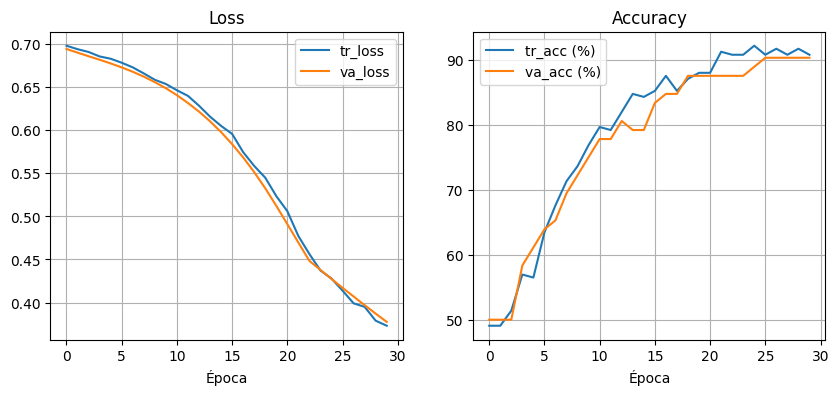

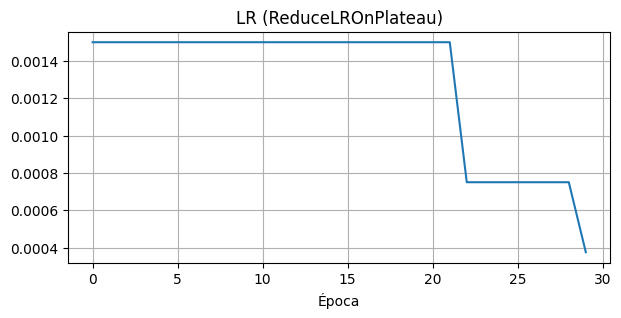

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(history["tr_loss"], label="tr_loss")
ax[0].plot(history["va_loss"], label="va_loss")
ax[0].set_title("Loss"); ax[0].set_xlabel("Época"); ax[0].grid(True); ax[0].legend()

ax[1].plot(np.array(history["tr_acc"])*100, label="tr_acc (%)")
ax[1].plot(np.array(history["va_acc"])*100, label="va_acc (%)")
ax[1].set_title("Accuracy"); ax[1].set_xlabel("Época"); ax[1].grid(True); ax[1].legend()
plt.show()

plt.figure(figsize=(7,3))
plt.plot(history["lr"])
plt.title("LR (ReduceLROnPlateau)"); plt.xlabel("Época"); plt.grid(True); plt.show()